In [1]:
import JSSP
import time
import numpy as np
import random
import gym
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style
import pandas as pd
import sys


from collections import defaultdict
#import plotting

# Environment Initialization

In [2]:
def create_env(instance_path):
    env_name = "JSSP-v0"
    env = gym.make(env_name, instance_path = instance_path)
    print("Environment Created for: ", instance_path)
    print("Observation space: \n", env.observation_space)
    print("Action space: \n", env.action_space)
    return env

In [3]:
env1 = create_env("instance1.txt")
env3 = create_env("instance3.txt")
env4 = create_env("instance4.txt")

Environment Created for:  instance1.txt
Observation space: 
 Box([-2 -2  0  0], [2 2 2 2], (4,), int64)
Action space: 
 Discrete(8)
Environment Created for:  instance3.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [10 10 10 10 10 10 10 10 10 10  9  9  9  9  9  9  9  9  9  9], (20,), int64)
Action space: 
 Discrete(260)
Environment Created for:  instance4.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5], (20,), int64)
Action space: 
 Discrete(756)


# Baselines

## 1. Random Sampling

In [4]:
def random_sampling(env, episodes):
    env.reset()
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []
    for episode in range(1, episodes+1):
        env.reset()
        done = False
        score = 0
        action_list = []
        time_list = []
        while not done:
            #env.render()
            action = env.action_space.sample()
            if action != env.action_space.n -1:
                action_list.append(env.legal_allocation_list[action])
                time_list.append(env.time)
                # print('Episode:{} Allocation:{} Time:{}'.format(episode, env.legal_allocation_list[action], env.time))
            n_state, reward, done, info = env.step(action)
            score+=reward
        # print('Episode:{} Total_reward:{}'.format(episode, score))
        if score >= max_score:
            max_score = score
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list
    print('From {}th Episode best policy has reward {}'.format(max_episode, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

## 2. Q-Learning

In [5]:
def policy(state, Q, epsilon, num_actions):
    """
    function that returns the probability for action choosing based on a given Q-function and epsilon at this state
    :param state: tuple of order 2 * number of jobs
    :param Q: Q table which is a dictionary with states as first class keys and actions as second class keys
    :param epsilon: for epsilon greedy choosing algorithm
    :param num_actions: number of legal actions at this state
    :return: an array of order num_actions containing probability for action choosing at this state
    """
    # if state has been visited before, use epsilon greedy algorithm to generate probability
    if state in Q:
        best_action = np.argmax(Q[state])
        Action_probabilities = np.ones(num_actions, dtype = float) * epsilon / num_actions
        Action_probabilities[best_action] += (1.0 - epsilon)
        return Action_probabilities

    # if state hasn't been visited before, choose action with equal probability
    Action_probabilities = np.ones(num_actions, dtype = float) / num_actions
    return Action_probabilities

In [6]:
def update(Q, state, next_state, action, reward, eta, gamma, threshold):
    """
    Q-table updating step
    :param Q: Q table which is a dictionary with states as first class keys and actions as second class keys
    :param state: current state which is a tuple of order 2 * number of jobs
    :param next_state: next state which is a tuple of order 2 * number of jobs
    :param action: action between current state and next state
    :param reward: reward for the action
    :param eta: learning rate
    :param gamma: discounted factor
    :return: updated Q table
    """
    # if next state has no data, set the maximum Q value to be 0
    if next_state not in Q:
        Q_next_state_max = 0
    else:
        Q_next_state_max = max(Q[next_state])

    # update the Q table iff the difference is larger than a threshold
    Q_update = eta * (reward + gamma * Q_next_state_max - Q[state][action])
    if abs(Q_update) >= threshold:
        Q[state][action] = Q[state][action] + Q_update

    return Q

In [27]:
def q_learning(env, epis, eta = .528, gamma = 1, epsilon = .3, threshold = 0.001):
    """
    q-learning algorithm that returns the best policy, and data for each episode
    :param threshold: Threshold for checking convergence of Q_table
    :param eta: learning rate, how much you accept the new value vs the old value
    :param gamma: discount factor, balance immediate and future reward
    :param epsilon: randomness factor, how random the selection is
    :param decay_rate: how much less randomness for each episode:
    :param env: JSSP instance
    :param epis: number of episodes
    :return: a list of total reward for each episode, the final Q_table, and a list of total reward every 100 episodes
    """
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []
    decay_rate = epsilon / epis

    # 1. Load Environment and Q-table structure
    Q_table = {}
    total_reward_list = [] # rewards per episode calculate
    testing_reward_list = [] # rewards per 100 episodes
    # 3. Q-learning Algorithm
    for episode in range(epis):
        # Reset environment
        state = env.reset()
        total_reward = 0
        done = False
        action_list = []
        time_list = []

        # Epsilon decay
        if epsilon > decay_rate:
            epsilon -= decay_rate
        # The Q-Table learning algorithm
        while not done:
            # initialize state in Q table
            if state not in Q_table:
                Q_table[state] = np.zeros(env.action_space.n)
            # generate action choosing probability and choose an action
            # if this is a testing episode, epsilon = 1
            action_probabilities = policy(state, Q_table, 0 if (episode % 100 == 0) else epsilon, env.action_space.n)
            action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)
            # update action history
            action_list.append(env.legal_allocation_list[action])
            time_list.append(env.time)
            # get new state & reward from environment
            next_state, reward, done, _ = env.step(action)
            #Update Q-Table with new knowledge
            Q_table = update(Q_table, state, next_state, action, reward, eta, gamma, threshold)
            total_reward += reward
            state = next_state
        total_reward_list.append(total_reward)
        # keep policy testing results every 100 episodes
        if episode % 100 == 0:
            testing_reward_list.append(total_reward)
            print("Episode: " + str(episode) + " has time " + str(env.time) + " has reward " + str(total_reward))
        # keep track of the optimal policy
        if total_reward >= max_score:
            max_score = total_reward
            max_episode = episode
            max_action_list = action_list
            max_time_list = time_list

    print('From {}th Episode best policy has reward {}'.format(max_episode + 1, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

    return total_reward_list, Q_table, testing_reward_list

training_reward_list, Q_table, testing_reward_list = q_learning(env3, 5000)

Episode: 0 has time 1245 has reward -1245
Episode: 100 has time 1477 has reward -1477
Episode: 200 has time 1518 has reward -1518
Episode: 300 has time 1255 has reward -1255
Episode: 400 has time 1432 has reward -1432
Episode: 500 has time 1156 has reward -1156
Episode: 600 has time 1286 has reward -1286
Episode: 700 has time 1309 has reward -1309
Episode: 800 has time 1339 has reward -1339
Episode: 900 has time 1414 has reward -1414
Episode: 1000 has time 1508 has reward -1508
Episode: 1100 has time 1169 has reward -1169
Episode: 1200 has time 1349 has reward -1349
Episode: 1300 has time 1196 has reward -1196
Episode: 1400 has time 1764 has reward -1764
Episode: 1500 has time 1119 has reward -1119
Episode: 1600 has time 1410 has reward -1410
Episode: 1700 has time 1331 has reward -1331
Episode: 1800 has time 1252 has reward -1252
Episode: 1900 has time 1448 has reward -1448
Episode: 2000 has time 1277 has reward -1277
Episode: 2100 has time 1238 has reward -1238
Episode: 2200 has time

# Analysis

## Random Sampling

In [174]:
random_sampling(env1, 100)

From 78th Episode best policy has reward -53
The allocation chose at time 0 is [1 0]
The allocation chose at time 15 is [ 2 -1]
The allocation chose at time 20 is [-1  1]
The allocation chose at time 38 is [-1  1]


## QLearning

In [191]:
training_reward_list, Q_table, testing_reward_list = q_learning(env1, 5000)

Episode: 0 has time 65 has reward -65
Episode: 1 has time 76 has reward -76
Episode: 2 has time 76 has reward -76
Episode: 3 has time 66 has reward -66
Episode: 4 has time 63 has reward -63
Episode: 5 has time 54 has reward -54
Episode: 6 has time 83 has reward -83
Episode: 7 has time 73 has reward -73
Episode: 8 has time 71 has reward -71
Episode: 9 has time 60 has reward -60
Episode: 10 has time 79 has reward -79
Episode: 11 has time 71 has reward -71
Episode: 12 has time 64 has reward -64
Episode: 13 has time 67 has reward -67
Episode: 14 has time 74 has reward -74
Episode: 15 has time 60 has reward -60
Episode: 16 has time 66 has reward -66
Episode: 17 has time 59 has reward -59
Episode: 18 has time 58 has reward -58
Episode: 19 has time 63 has reward -63
Episode: 20 has time 69 has reward -69
Episode: 21 has time 65 has reward -65
Episode: 22 has time 72 has reward -72
Episode: 23 has time 65 has reward -65
Episode: 24 has time 60 has reward -60
Episode: 25 has time 64 has reward 

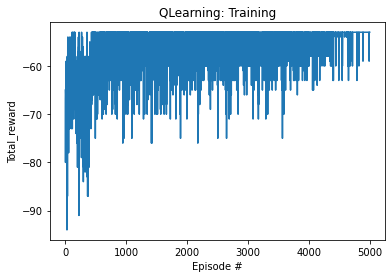

In [25]:
plt.plot(training_reward_list)
plt.title("QLearning: Training")
plt.xlabel("Episode #")
plt.ylabel("Total_reward")
plt.show()

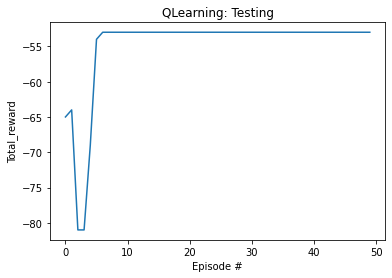

In [26]:
plt.plot(testing_reward_list)
plt.title("QLearning: Testing")
plt.xlabel("Episode #")
plt.ylabel("Total_reward")
plt.show()

In [286]:
print(Q_table)

KeyboardInterrupt: 